In [2]:
import numpy as np
import pandas as pd
import sys
import pickle
import csv
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from statsmodels.stats import diagnostic
from scipy import stats

### Part I. Find out if race search is related to population proportion in a state

We read state stop data here.

In [2]:
df = pd.read_csv('state.csv',
                 sep=',',
                 encoding='utf-8',
                 error_bad_lines=False,
                 warn_bad_lines=False)
#read_csv ignore bad line and warn lines


In [3]:
df.groupby('state').count()

,city,geography,subgeography,subject_race,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n
state,,,,,,,,,,
AZ,48,48,45,48,0,48,0,0,48,48
CA,177,177,174,177,0,177,0,0,177,177
CO,193,193,192,193,0,193,0,0,193,193
CT,27,27,24,27,21,27,21,21,27,27
FL,221,221,221,221,0,221,0,0,221,221
GA,480,480,480,480,0,480,0,0,480,480
IL,112,112,112,112,60,112,60,60,112,112
MA,45,45,42,45,0,45,0,0,45,45
MT,174,174,173,174,0,174,0,0,174,174


We can see we have 21 different state's data here.Now according to https://www.census.gov/quickfacts/ ，We can get data on the proportion of different races in each state.

In [4]:
race = pd.read_csv('races.csv',
                 sep=',',
                 encoding='utf-8',
                 error_bad_lines=False,
                 warn_bad_lines=False)

We sort by the percentage of white people in a state's population.

In [5]:
race=race.sort_values('white').reset_index(drop=True).set_index('state')

In [6]:
race

,white,hispanic,black
state,,,
CA,0.365,0.394,0.065
TX,0.412,0.397,0.129
GA,0.520,0.099,0.326
FL,0.532,0.264,0.169
AZ,0.541,0.317,0.052
NY,0.553,0.193,0.176
IL,0.608,0.175,0.146
NC,0.626,0.098,0.222
SC,0.637,0.060,0.270


Visualize the data,We can see that the ethnic composition of some states is very diverse. In some states, the ethnic composition is relatively single, with a certain ethnicity occupying the majority.

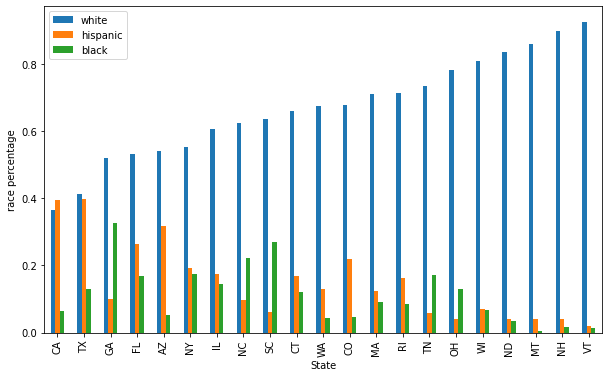

In [7]:
race.plot.bar(figsize=(10,6))
plt.xlabel('State')
plt.ylabel('race percentage')
plt.show()

Now let’s define the state with diverse ethnic composition as a diverse state, and a state with an absolute majority of whites as a poor diverse state.

The following will select several states with obvious characteristics for data analysis.


Diverse state:CA,TX,GA


Poor diverse state: MT,NH,VT

The passage mentioned that drivers may not live in the jurisdictions where they were stopped. For the statistical data city.csv with the city as the unit, this conclusion is likely to be established, but if we use the state as the unit to calculate the data, because the intra-state traffic flow is definitely much larger than the interstate traffic flow. Drivers who are stopped are likely to belong to this state, so we can approximate the overall driver racial composition of this state based on the proportion of the state’s population.

The first test is based on a simple assumption. If the police treat drivers of all races equally, then the total number of stoppages for drivers of all races in the state in a year should be approximated by the total number of stoppages in the state multiplied by the race's population proportion in the state. proportion.

In [8]:
df_search=df[['state','stops_per_year']].copy()
df_search['search_count']=df_search.groupby('state').transform('sum')

#get the sum of search per state

In [9]:
df_search=df_search.drop_duplicates(subset=['state','search_count'],keep='first').drop(columns=['stops_per_year'])
#drop duplicates row , we only need 1 row for each state

In [10]:
df_search=df_search.reset_index(drop=True)
#reset index

We can get the total search number of different states below.

In [11]:
df_search

,state,search_count
0,AZ,4.719596e+05
1,CA,3.753145e+06
2,CO,3.192967e+05
3,CT,2.079549e+05
4,FL,7.945570e+05
5,GA,2.039889e+05
6,IL,3.054684e+05
7,MA,3.547447e+05
8,MT,1.080752e+05
9,NC,7.767380e+05


In [12]:
race=pd.merge(race,df_search,on='state')
#merge data

In [13]:
race

,state,white,hispanic,black,search_count
0,CA,0.365,0.394,0.065,3.753145e+06
1,TX,0.412,0.397,0.129,2.031018e+06
2,GA,0.520,0.099,0.326,2.039889e+05
3,FL,0.532,0.264,0.169,7.945570e+05
4,AZ,0.541,0.317,0.052,4.719596e+05
5,NY,0.553,0.193,0.176,9.220233e+05
6,IL,0.608,0.175,0.146,3.054684e+05
7,NC,0.626,0.098,0.222,7.767380e+05
8,SC,0.637,0.060,0.270,7.694539e+05
9,CT,0.659,0.169,0.122,2.079549e+05


As above,If the police treat drivers of all races equally, then the expected number of search for drivers of all races in the state in a year should be total search* the percentage of this race in the state.

In [14]:
race['ex_white_stop']=race['search_count']*race['white']
race['ex_black_stop']=race['search_count']*race['black']
race['ex_hispanic_stop']=race['search_count']*race['hispanic']
#calcute expected number

In [15]:
race=race.sort_values(by='state').reset_index(drop=True)
#reset index

In [16]:
race

,state,white,hispanic,black,search_count,ex_white_stop,ex_black_stop,ex_hispanic_stop
0,AZ,0.541,0.317,0.052,4.719596e+05,2.553301e+05,24541.898372,1.496112e+05
1,CA,0.365,0.394,0.065,3.753145e+06,1.369898e+06,243954.454182,1.478739e+06
2,CO,0.677,0.218,0.046,3.192967e+05,2.161639e+05,14687.650120,6.960669e+04
3,CT,0.659,0.169,0.122,2.079549e+05,1.370423e+05,25370.497800,3.514438e+04
4,FL,0.532,0.264,0.169,7.945570e+05,4.227043e+05,134280.135500,2.097631e+05
5,GA,0.520,0.099,0.326,2.039889e+05,1.060742e+05,66500.380418,2.019490e+04
6,IL,0.608,0.175,0.146,3.054684e+05,1.857248e+05,44598.382022,5.345696e+04
7,MA,0.711,0.124,0.090,3.547447e+05,2.522235e+05,31927.019548,4.398834e+04
8,MT,0.859,0.041,0.006,1.080752e+05,9.283659e+04,648.451168,4.431083e+03
9,NC,0.626,0.098,0.222,7.767380e+05,4.862380e+05,172435.830387,7.612032e+04


Now we calculate the real number of search for per races in different state.

In [17]:
df_wh=df[df['subject_race']=='white']
df_b=df[df['subject_race']=='black']
df_h=df[df['subject_race']=='hispanic']
#select race

In [18]:
df_wh=df_wh[['state','stops_per_year']].copy()
df_b=df_b[['state','stops_per_year']].copy()
df_h=df_h[['state','stops_per_year']].copy()
#select columns we need

In [19]:
df_wh['total']=df_wh.groupby('state').transform('sum')
df_b['total']=df_b.groupby('state').transform('sum')
df_h['total']=df_h.groupby('state').transform('sum')
#calculate the sum

In [20]:
df_wh['race']='white'
df_b['race']='black'
df_h['race']='hispanic'
#set race for merge

In [21]:
df_wh=df_wh.drop_duplicates(subset=['state','total'],keep='first').drop(columns=['stops_per_year']).reset_index(drop=True)
df_b=df_b.drop_duplicates(subset=['state','total'],keep='first').drop(columns=['stops_per_year']).reset_index(drop=True)
df_h=df_h.drop_duplicates(subset=['state','total'],keep='first').drop(columns=['stops_per_year']).reset_index(drop=True)
#drop column we don't need

In [22]:
df_wh

,state,total,race
0,AZ,2.982756e+05,white
1,CA,1.917549e+06,white
2,CO,2.615949e+05,white
3,CT,1.601313e+05,white
4,FL,4.616676e+05,white
5,GA,1.346266e+05,white
6,IL,2.113327e+05,white
7,MA,2.760790e+05,white
8,MT,1.037304e+05,white
9,NC,5.228150e+05,white


In [23]:
race['white_stop']=df_wh['total']
race['black_stop']=df_b['total']
race['hispanic_stop']=df_h['total']
#add new column

In [24]:
race

,state,white,hispanic,black,search_count,ex_white_stop,ex_black_stop,ex_hispanic_stop,white_stop,black_stop,hispanic_stop
0,AZ,0.541,0.317,0.052,4.719596e+05,2.553301e+05,24541.898372,1.496112e+05,2.982756e+05,32779.643873,1.409043e+05
1,CA,0.365,0.394,0.065,3.753145e+06,1.369898e+06,243954.454182,1.478739e+06,1.917549e+06,364642.903497,1.470953e+06
2,CO,0.677,0.218,0.046,3.192967e+05,2.161639e+05,14687.650120,6.960669e+04,2.615949e+05,11073.559445,4.662829e+04
3,CT,0.659,0.169,0.122,2.079549e+05,1.370423e+05,25370.497800,3.514438e+04,1.601313e+05,25884.140000,2.193944e+04
4,FL,0.532,0.264,0.169,7.945570e+05,4.227043e+05,134280.135500,2.097631e+05,4.616676e+05,160792.305313,1.720971e+05
5,GA,0.520,0.099,0.326,2.039889e+05,1.060742e+05,66500.380418,2.019490e+04,1.346266e+05,61265.368729,8.096920e+03
6,IL,0.608,0.175,0.146,3.054684e+05,1.857248e+05,44598.382022,5.345696e+04,2.113327e+05,64528.917436,2.960674e+04
7,MA,0.711,0.124,0.090,3.547447e+05,2.522235e+05,31927.019548,4.398834e+04,2.760790e+05,40230.898004,3.843476e+04
8,MT,0.859,0.041,0.006,1.080752e+05,9.283659e+04,648.451168,4.431083e+03,1.037304e+05,1738.697221,2.606114e+03
9,NC,0.626,0.098,0.222,7.767380e+05,4.862380e+05,172435.830387,7.612032e+04,5.228150e+05,198974.175607,5.494879e+04


In [25]:
race['bias_wh']=race['white_stop']-race['ex_white_stop']
race['bias_b']=race['black_stop']-race['ex_black_stop']
race['bias_h']=race['hispanic_stop']-race['ex_hispanic_stop']

Then we can see the bias bewtween estimated value and real value from the columns bias.

In [26]:
race

,state,white,hispanic,black,search_count,ex_white_stop,ex_black_stop,ex_hispanic_stop,white_stop,black_stop,hispanic_stop,bias_wh,bias_b,bias_h
0,AZ,0.541,0.317,0.052,4.719596e+05,2.553301e+05,24541.898372,1.496112e+05,2.982756e+05,32779.643873,1.409043e+05,42945.509650,8237.745502,-8706.892585
1,CA,0.365,0.394,0.065,3.753145e+06,1.369898e+06,243954.454182,1.478739e+06,1.917549e+06,364642.903497,1.470953e+06,547651.365678,120688.449315,-7786.215978
2,CO,0.677,0.218,0.046,3.192967e+05,2.161639e+05,14687.650120,6.960669e+04,2.615949e+05,11073.559445,4.662829e+04,45430.994902,-3614.090675,-22978.396464
3,CT,0.659,0.169,0.122,2.079549e+05,1.370423e+05,25370.497800,3.514438e+04,1.601313e+05,25884.140000,2.193944e+04,23089.040900,513.642200,-13204.938100
4,FL,0.532,0.264,0.169,7.945570e+05,4.227043e+05,134280.135500,2.097631e+05,4.616676e+05,160792.305313,1.720971e+05,38963.293132,26512.169814,-37665.967427
5,GA,0.520,0.099,0.326,2.039889e+05,1.060742e+05,66500.380418,2.019490e+04,1.346266e+05,61265.368729,8.096920e+03,28552.382054,-5235.011688,-12097.981032
6,IL,0.608,0.175,0.146,3.054684e+05,1.857248e+05,44598.382022,5.345696e+04,2.113327e+05,64528.917436,2.960674e+04,25607.943443,19930.535414,-23850.224586
7,MA,0.711,0.124,0.090,3.547447e+05,2.522235e+05,31927.019548,4.398834e+04,2.760790e+05,40230.898004,3.843476e+04,23855.545573,8303.878457,-5553.574407
8,MT,0.859,0.041,0.006,1.080752e+05,9.283659e+04,648.451168,4.431083e+03,1.037304e+05,1738.697221,2.606114e+03,10893.791063,1090.246053,-1824.968812
9,NC,0.626,0.098,0.222,7.767380e+05,4.862380e+05,172435.830387,7.612032e+04,5.228150e+05,198974.175607,5.494879e+04,36577.041797,26538.345220,-21171.536381


However, because the total number of searches in each state is different, bias does not intuitively reflect whether the state police discriminates when searching for drivers.


So we propose a coefficient here to reflect whether there is a difference between the diverse state and the poor diverse state. Assuming that the total number of white residents in a state is n times that of blacks, under other conditions, the total number of stoppages for white drivers should be approximately n times that of black drivers.

                        ratio1=white/black or white/hispanic

This ratio represents the multiple relationship between whites and minorities.

                        ratio2=white driver search number/ minorities search number(black or hispanic)

This ratio represents the multiple relationship between whites search number and minorities number.

                        coefficient=ratio1/ratio2


According to our assumptions, this coefficient should be about 1. If it is greater than 1, it means that the actual minority searched by the local police is larger than the estimated value, which means that they are more inclined to search for minority drivers.

In [27]:
race['w_b_ratio']=race['white']/race['black']
race['stop_w_b_ratio']=race['white_stop']/race['black_stop']
race['w_h_ratio']=race['white']/race['hispanic']
race['stop_w_h_ratio']=race['white_stop']/race['hispanic_stop']
#calculate ratio 1 and ratio 2

In [28]:
race

,state,white,hispanic,black,search_count,ex_white_stop,ex_black_stop,ex_hispanic_stop,white_stop,black_stop,hispanic_stop,bias_wh,bias_b,bias_h,w_b_ratio,stop_w_b_ratio,w_h_ratio,stop_w_h_ratio
0,AZ,0.541,0.317,0.052,4.719596e+05,2.553301e+05,24541.898372,1.496112e+05,2.982756e+05,32779.643873,1.409043e+05,42945.509650,8237.745502,-8706.892585,10.403846,9.099417,1.706625,2.116867
1,CA,0.365,0.394,0.065,3.753145e+06,1.369898e+06,243954.454182,1.478739e+06,1.917549e+06,364642.903497,1.470953e+06,547651.365678,120688.449315,-7786.215978,5.615385,5.258705,0.926396,1.303610
2,CO,0.677,0.218,0.046,3.192967e+05,2.161639e+05,14687.650120,6.960669e+04,2.615949e+05,11073.559445,4.662829e+04,45430.994902,-3614.090675,-22978.396464,14.717391,23.623379,3.105505,5.610218
3,CT,0.659,0.169,0.122,2.079549e+05,1.370423e+05,25370.497800,3.514438e+04,1.601313e+05,25884.140000,2.193944e+04,23089.040900,513.642200,-13204.938100,5.401639,6.186465,3.899408,7.298788
4,FL,0.532,0.264,0.169,7.945570e+05,4.227043e+05,134280.135500,2.097631e+05,4.616676e+05,160792.305313,1.720971e+05,38963.293132,26512.169814,-37665.967427,3.147929,2.871205,2.015152,2.682600
5,GA,0.520,0.099,0.326,2.039889e+05,1.060742e+05,66500.380418,2.019490e+04,1.346266e+05,61265.368729,8.096920e+03,28552.382054,-5235.011688,-12097.981032,1.595092,2.197434,5.252525,16.626892
6,IL,0.608,0.175,0.146,3.054684e+05,1.857248e+05,44598.382022,5.345696e+04,2.113327e+05,64528.917436,2.960674e+04,25607.943443,19930.535414,-23850.224586,4.164384,3.275008,3.474286,7.137993
7,MA,0.711,0.124,0.090,3.547447e+05,2.522235e+05,31927.019548,4.398834e+04,2.760790e+05,40230.898004,3.843476e+04,23855.545573,8303.878457,-5553.574407,7.900000,6.862362,5.733871,7.183054
8,MT,0.859,0.041,0.006,1.080752e+05,9.283659e+04,648.451168,4.431083e+03,1.037304e+05,1738.697221,2.606114e+03,10893.791063,1090.246053,-1824.968812,143.166667,59.659832,20.951220,39.802701
9,NC,0.626,0.098,0.222,7.767380e+05,4.862380e+05,172435.830387,7.612032e+04,5.228150e+05,198974.175607,5.494879e+04,36577.041797,26538.345220,-21171.536381,2.819820,2.627552,6.387755,9.514587


In [29]:
race['coefficient_white_black']=race['w_b_ratio']/race['stop_w_b_ratio']
race['coefficient_white_hispanic']=race['w_h_ratio']/race['stop_w_h_ratio']
#calculate coefficient

In [30]:
race

,state,white,hispanic,black,search_count,ex_white_stop,ex_black_stop,ex_hispanic_stop,white_stop,black_stop,hispanic_stop,bias_wh,bias_b,bias_h,w_b_ratio,stop_w_b_ratio,w_h_ratio,stop_w_h_ratio,coefficient_white_black,coefficient_white_hispanic
0,AZ,0.541,0.317,0.052,4.719596e+05,2.553301e+05,24541.898372,1.496112e+05,2.982756e+05,32779.643873,1.409043e+05,42945.509650,8237.745502,-8706.892585,10.403846,9.099417,1.706625,2.116867,1.143353,0.806203
1,CA,0.365,0.394,0.065,3.753145e+06,1.369898e+06,243954.454182,1.478739e+06,1.917549e+06,364642.903497,1.470953e+06,547651.365678,120688.449315,-7786.215978,5.615385,5.258705,0.926396,1.303610,1.067827,0.710639
2,CO,0.677,0.218,0.046,3.192967e+05,2.161639e+05,14687.650120,6.960669e+04,2.615949e+05,11073.559445,4.662829e+04,45430.994902,-3614.090675,-22978.396464,14.717391,23.623379,3.105505,5.610218,0.623001,0.553544
3,CT,0.659,0.169,0.122,2.079549e+05,1.370423e+05,25370.497800,3.514438e+04,1.601313e+05,25884.140000,2.193944e+04,23089.040900,513.642200,-13204.938100,5.401639,6.186465,3.899408,7.298788,0.873138,0.534254
4,FL,0.532,0.264,0.169,7.945570e+05,4.227043e+05,134280.135500,2.097631e+05,4.616676e+05,160792.305313,1.720971e+05,38963.293132,26512.169814,-37665.967427,3.147929,2.871205,2.015152,2.682600,1.096379,0.751193
5,GA,0.520,0.099,0.326,2.039889e+05,1.060742e+05,66500.380418,2.019490e+04,1.346266e+05,61265.368729,8.096920e+03,28552.382054,-5235.011688,-12097.981032,1.595092,2.197434,5.252525,16.626892,0.725888,0.315905
6,IL,0.608,0.175,0.146,3.054684e+05,1.857248e+05,44598.382022,5.345696e+04,2.113327e+05,64528.917436,2.960674e+04,25607.943443,19930.535414,-23850.224586,4.164384,3.275008,3.474286,7.137993,1.271564,0.486731
7,MA,0.711,0.124,0.090,3.547447e+05,2.522235e+05,31927.019548,4.398834e+04,2.760790e+05,40230.898004,3.843476e+04,23855.545573,8303.878457,-5553.574407,7.900000,6.862362,5.733871,7.183054,1.151207,0.798250
8,MT,0.859,0.041,0.006,1.080752e+05,9.283659e+04,648.451168,4.431083e+03,1.037304e+05,1738.697221,2.606114e+03,10893.791063,1090.246053,-1824.968812,143.166667,59.659832,20.951220,39.802701,2.399716,0.526377
9,NC,0.626,0.098,0.222,7.767380e+05,4.862380e+05,172435.830387,7.612032e+04,5.228150e+05,198974.175607,5.494879e+04,36577.041797,26538.345220,-21171.536381,2.819820,2.627552,6.387755,9.514587,1.073174,0.671364


Now we check is there any difference between Diverse state and poor Diverse state.

In [31]:
diverse_state=race.query("state==['CA','TX','GA']")[['state','coefficient_white_black','coefficient_white_hispanic']]

In [32]:
p_diverse_state=race.query("state==['MT','NH','VT']")[['state','coefficient_white_black','coefficient_white_hispanic']]

In [33]:
diverse_state

,state,coefficient_white_black,coefficient_white_hispanic
1,CA,1.067827,0.710639
5,GA,0.725888,0.315905
17,TX,0.642851,0.721607


In [34]:
p_diverse_state

,state,coefficient_white_black,coefficient_white_hispanic
8,MT,2.399716,0.526377
11,NH,1.341656,0.391117
18,VT,1.495513,0.538128


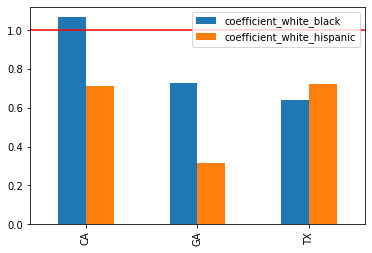

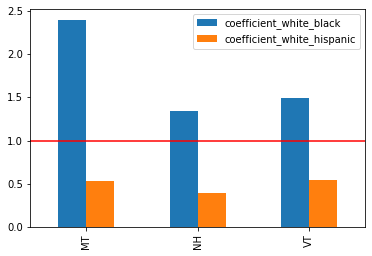

In [35]:
diverse_state.plot.bar()
plt.axhline(y=1,c='red')
plt.xticks(np.arange(3),diverse_state['state'])
p_diverse_state.plot.bar()
plt.axhline(y=1,c='red')
plt.xticks(np.arange(3),p_diverse_state['state'])
plt.show()

We can see that in poor diverse states, the coefficient between blacks and whites is much greater than 1, which proves that police in this state are more inclined to search for black drivers.

In [36]:
stats.pearsonr(race['white'],race['coefficient_white_black'])

(0.4423737113517777, 0.044637086701388606)

There is a small (0.44), but significant (p < 0.05) positive correlation.This shows that the proportion of whites in a state has a strong correlation with this coefficient.

The above analysis has some shortcomings,
For example, black drivers may have worse driving skills and other objective factors, but this partially reveals that in states where whites dominate, black drivers are more likely to be searched, and there may be racial disparities in traffic stops.

### Part II. Find whether the partisan politics has effects on the traffic stop rates. 

We get information from the wiki:https://en.wikipedia.org/wiki/Red_states_and_blue_states, if a state became ticket warehouse of Democratic Party since 1992(Data from a long time ago has no reference to the political situation in the United States today), that is a blue state. On the contrary, if a state became ticket warehouse of Republican Party since 1992(since 1992, the presidential election situation in some U.S. states was relatively stable, except for swing states), that is a red state.

### The results is following:

Red States:
1.Alabama(AL) 2.Alaska(AK) 3.Idaho(ID) 4.Kansas(KS) 5.Mississippi(MS) 6.North Dakota(ND) 7.Oklahoma(OK) 8.South Carolina(SC) 9.South Dakota(SD) 10.Texas(TX) 11.Utah(UT) 12.Wyoming(WY)

Blue States:
1.California(CA) 2.Connecticut(CT) 3.Delaware(DE) 4.Washington D.C.(WDC) 5.Hawaii(HI) 6.Illinois(IL) 7.Maryland(MD) 8.Massachusetts(MA) 9.Minnesota(MN) 10.New Jersey(NJ) 11.New York(NY) 12.Oregon(OR) 13.Rhode Island(RI) 14.Vermont(VT) 15.Washington(WA)

According to the data given by the paper and the data we collected, we decide to use the following states to analyze the traffic stop rates.
Red States:1.ND 2.SC 3.TX
Blue States: 1.CA 2.CT 3.IL 4.MA 5.NY 6.RI 7.VT 8.WA

Considering many matching factors, we let those three pairs of states to compare because their population and composition are similar.

1.CA and TX
2.CT and SC
3.VT and ND

In [52]:
states_info = pd.read_csv('states_info.csv',
                 sep=',',
                 encoding='utf-8',
                 error_bad_lines=False,
                 warn_bad_lines=False)
#read_csv ignore bad line and warn lines
states_info

,state,population,white_rate,hispanic_rate,black_rate,others_rate
0,CA,3953.66,0.365,0.394,0.065,0.176
1,CT,359.08,0.659,0.169,0.122,0.050
2,IL,1280.20,0.608,0.175,0.146,0.071
3,MA,654.78,0.711,0.124,0.090,0.075
4,ND,64.22,0.837,0.041,0.034,0.088
5,NY,1984.93,0.553,0.193,0.176,0.078
6,RI,110.88,0.714,0.163,0.085,0.038
7,SC,432.12,0.637,0.060,0.270,0.033
8,TX,2830.46,0.412,0.397,0.129,0.062
9,VT,62.65,0.926,0.020,0.014,0.040


We get the detailed population information of the above states. We standardize all the data.

In [53]:
states_info['blue_or_red'] = ['blue','blue','blue','blue','red','blue','blue','red','red','blue','blue']

maxpopulation = np.max(states_info['population'])
states_info['population'] = states_info['population']/maxpopulation
states_info

,state,population,white_rate,hispanic_rate,black_rate,others_rate,blue_or_red
0,CA,1.000000,0.365,0.394,0.065,0.176,blue
1,CT,0.090822,0.659,0.169,0.122,0.050,blue
2,IL,0.323801,0.608,0.175,0.146,0.071,blue
3,MA,0.165614,0.711,0.124,0.090,0.075,blue
4,ND,0.016243,0.837,0.041,0.034,0.088,red
5,NY,0.502049,0.553,0.193,0.176,0.078,blue
6,RI,0.028045,0.714,0.163,0.085,0.038,blue
7,SC,0.109296,0.637,0.060,0.270,0.033,red
8,TX,0.715909,0.412,0.397,0.129,0.062,red
9,VT,0.015846,0.926,0.020,0.014,0.040,blue


In [54]:
states_info = states_info.sort_values(by='blue_or_red', ascending=False).reset_index(drop=True)
states_info

,state,population,white_rate,hispanic_rate,black_rate,others_rate,blue_or_red
0,ND,0.016243,0.837,0.041,0.034,0.088,red
1,SC,0.109296,0.637,0.060,0.270,0.033,red
2,TX,0.715909,0.412,0.397,0.129,0.062,red
3,CA,1.000000,0.365,0.394,0.065,0.176,blue
4,CT,0.090822,0.659,0.169,0.122,0.050,blue
5,IL,0.323801,0.608,0.175,0.146,0.071,blue
6,MA,0.165614,0.711,0.124,0.090,0.075,blue
7,NY,0.502049,0.553,0.193,0.176,0.078,blue
8,RI,0.028045,0.714,0.163,0.085,0.038,blue
9,VT,0.015846,0.926,0.020,0.014,0.040,blue


The most used way to calculate the differences of states is to calculate different kinds of distance or the similarity coefficient between states in all demensions. But they all have problems. To deal with this, we can just calculate the euclidean distance(other distance result is the same in this situation because states vary too much from each other) to find two similar red and blue states, and take their differences into consideration in further talking and analysis.

In [55]:
for i in np.arange(0,3):
    print(states_info['state'][i],'closest state is')
    difference = sys.maxsize
    loss = [sys.maxsize,sys.maxsize,sys.maxsize]
    for j in np.arange(3,11):
        loss.append(np.sqrt((states_info['population'][i]-states_info['population'][j])**2
        +(states_info['white_rate'][i]-states_info['white_rate'][j])**2
        +(states_info['hispanic_rate'][i]-states_info['hispanic_rate'][j])**2
        +(states_info['black_rate'][i]-states_info['black_rate'][j])**2))
    print(states_info['state'][loss.index(np.min(loss))])
    
    

ND closest state is
VT
SC closest state is
CT
TX closest state is
CA


The upper result shows our choices are right in distance calculation deciding similarity!

In [56]:
states_info = states_info.drop('blue_or_red',axis=1)

<AxesSubplot:>

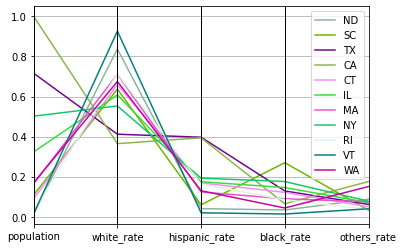

In [57]:
from pandas.plotting import parallel_coordinates
plt.figure()
parallel_coordinates(states_info,'state')

In [58]:
CA_TX=race.query("state==['CA','TX']")[['state','coefficient_white_black','coefficient_white_hispanic']]

In [59]:
CA_TX

,state,coefficient_white_black,coefficient_white_hispanic
1,CA,1.067827,0.710639
17,TX,0.642851,0.721607


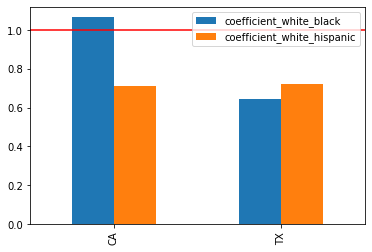

In [60]:
CA_TX.plot.bar()
plt.axhline(y=1,c='red')
plt.xticks(np.arange(2),CA_TX['state'])
plt.show()

In [61]:
CT_SC=race.query("state==['CT','SC']")[['state','coefficient_white_black','coefficient_white_hispanic']]

In [62]:
CT_SC

,state,coefficient_white_black,coefficient_white_hispanic
3,CT,0.873138,0.534254
15,SC,1.305692,0.681189


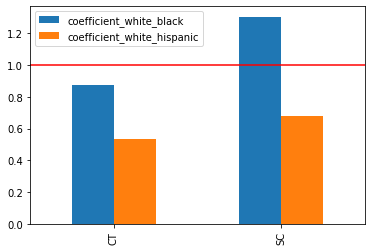

In [63]:
CT_SC.plot.bar()
plt.axhline(y=1,c='red')
plt.xticks(np.arange(2),CT_SC['state'])
plt.show()

In [64]:
VT_ND=race.query("state==['VT','ND']")[['state','coefficient_white_black','coefficient_white_hispanic']]

In [65]:
VT_ND

,state,coefficient_white_black,coefficient_white_hispanic
10,ND,1.064803,0.805060
18,VT,1.495513,0.538128


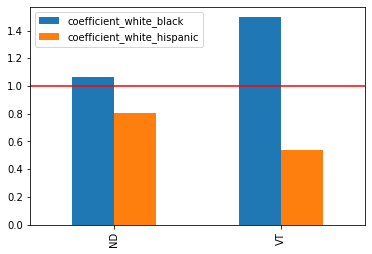

In [66]:
VT_ND.plot.bar()
plt.axhline(y=1,c='red')
plt.xticks(np.arange(2),VT_ND['state'])
plt.show()

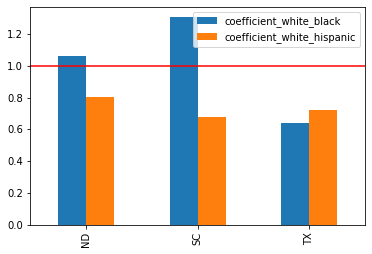

In [67]:
all_red_state=race.query("state==['TX','SC','ND']")[['state','coefficient_white_black','coefficient_white_hispanic']]
all_red_state.plot.bar()
plt.axhline(y=1,c='red')
plt.xticks(np.arange(3),all_red_state['state'])
plt.show()

In [68]:
all_blue_state = race.query("state==['CA','CT','IL','MA','NY','RI','VT','WA']")[['state','coefficient_white_black','coefficient_white_hispanic']]

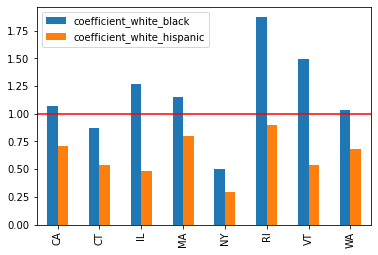

In [69]:
all_blue_state.plot.bar()
plt.axhline(y=1,c='red')
plt.xticks(np.arange(8),all_blue_state['state'])
plt.show()

In [70]:
all_21_state = race.query("state==['AZ', 'CA', 'CO', 'CT', 'FL', 'GA', 'IL', 'MA', 'MT', 'NC', 'ND', 'NH', 'NY', 'OH', 'RI', 'SC', 'TN', 'TX', 'VT', 'WA', 'WI']")[['state','coefficient_white_black','coefficient_white_hispanic']]
all_21_state

,state,coefficient_white_black,coefficient_white_hispanic
0,AZ,1.143353,0.806203
1,CA,1.067827,0.710639
2,CO,0.623001,0.553544
3,CT,0.873138,0.534254
4,FL,1.096379,0.751193
5,GA,0.725888,0.315905
6,IL,1.271564,0.486731
7,MA,1.151207,0.798250
8,MT,2.399716,0.526377
9,NC,1.073174,0.671364


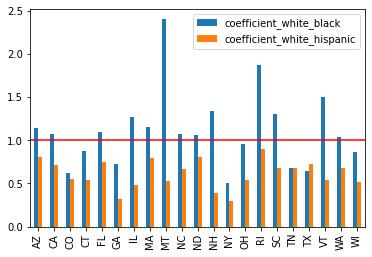

In [71]:
all_21_state.plot.bar()
plt.axhline(y=1,c='red')
plt.xticks(np.arange(21),all_21_state['state'])
plt.show()

We also find a more interesting question from the upper figure: Are black and hispanic treated differently in the traffic stops? It seems the black are under a worse situation.

From the former analysis, we find that maybe the black seems to be treated badly when comparing to hispanic.

We get crime rates from the US Department of Justice. Their website is https://www.ojjdp.gov/ojstatbb/crime/ucr.asp?table_in=2&selYrs=2019&rdoGroups=1&rdoData=c

In [72]:
crime_rate = pd.read_csv('crime_rates.csv',
                 sep=',',
                 encoding='utf-8',
                 error_bad_lines=False,
                 warn_bad_lines=False)
#read_csv ignore bad line and warn lines
crime_rate

,Year,Offenses,All races,White,Black,American Indian,Asian
0,2019,All offenses,10085210,7014550,2667010,244200,159450
1,2018,All offenses,10310960,7115940,2826460,219410,149150
2,2017,All offenses,10554990,7277670,2870440,254080,152800
3,2016,All offenses,10662250,7418700,2863810,216530,163210
4,2015,All offenses,10797090,7531830,2875140,227240,162880
5,2014,All offenses,11205830,7771220,3114810,173710,146100
6,2013,All offenses,11302100,7809270,3173490,176920,142420
7,2012,All offenses,12196960,8417780,3420690,177110,181390
8,2011,All offenses,12408900,8595810,3474350,187820,150920
9,2010,All offenses,13120950,9121270,3655210,186110,158360


In [73]:
crime_rate = crime_rate.sort_values('Year').reset_index(drop=True)
crime_rate['White_Rate'] = crime_rate['White']/crime_rate['All races']
crime_rate['Black_Rate'] = crime_rate['Black']/crime_rate['All races']
crime_rate

,Year,Offenses,All races,White,Black,American Indian,Asian,White_Rate,Black_Rate
0,2000,All offenses,13838320,9522510,3997710,176380,141720,0.688126,0.288887
1,2001,All offenses,13566000,9337370,3919580,164960,144080,0.688292,0.288927
2,2002,All offenses,13615750,9545770,3733430,180300,156250,0.701083,0.274199
3,2003,All offenses,13515900,9470310,3714240,178900,152440,0.700679,0.274805
4,2004,All offenses,13818730,9734790,3754100,178510,151320,0.704463,0.271668
5,2005,All offenses,13985230,9793980,3857280,186510,147470,0.700309,0.275811
6,2006,All offenses,14266190,9991090,3940410,182310,152380,0.700333,0.276206
7,2007,All offenses,14100490,9857970,3903410,184820,154290,0.699123,0.276828
8,2008,All offenses,13896390,9681250,3876250,182270,156620,0.696674,0.278939
9,2009,All offenses,13593810,9442890,3805440,188450,157040,0.694646,0.279939


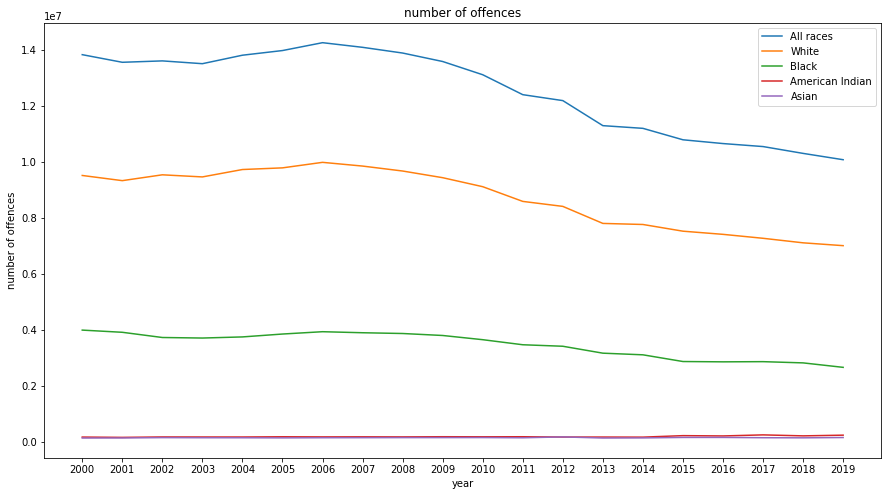

In [74]:
plt.figure(figsize=(15,8))

#define picture pixels and resolution
#plt.rcParams['savefig.dpi'] = 500 
#plt.rcParams['figure.dpi'] = 500 

x = crime_rate['Year']
#fig,ax = plt.subplots()
plt.plot(x,crime_rate['All races'],label='All races')
plt.plot(x,crime_rate['White'],label='White')
plt.plot(x,crime_rate['Black'],label='Black')
plt.plot(x,crime_rate['American Indian'],label='American Indian')
plt.plot(x,crime_rate['Asian'],label='Asian')

#plt.xlim(2000,2019)


new_ticks = np.linspace(2000,2019,20)
plt.xticks(new_ticks)

plt.xlabel('year')
plt.ylabel('number of offences')
plt.title('number of offences')
plt.legend()
plt.show()


Because rate changes very little, we can use the average rate to represent.

In [75]:
average_white_rate = sum(crime_rate['White_Rate'])/crime_rate.shape[0]
average_white_rate

0.6952376459255899

In [76]:
average_black_rate = sum(crime_rate['Black_Rate'])/crime_rate.shape[0]
average_black_rate

0.27646919059752534

According to Wikipedia, white people(non-hispanic) account for around 65.73% of total U.S. population in the former 20 years. Black people account for 12.59%. Hispanic people account for 15.24%. It seems prior experience gives the reason why the black are treated unfairly. However, this has problems. One most important reason is that here is all offenses. However, during driving, not all offenses should be calculated because some offenses cannot be done during driving. If these offences have large bias, these can lead to the racial disparities. Also, these offences are calculated of offences conducted in U.S. If someone come from other countries and does something wrong in U.S., this will also be included. Now most visitors in U.S. are not white. This may also have influences. There are also other reasons and the data given by the US Department of Justice also has problems, for example, they don't distinguish white and hispanic, so this is very difficult for us to get more information and comparison in this way.

### Part III. Find out if inferred threshold of a certain race is related to its population proportion in a state

Comparing the thresholds for searching the different races of drivers is one research topic of the paper.
In the paper, there is a conclusion that the inferred thresholds for searching black and Hispanic drivers are typically lower than those for searching white drivers. On this basis, we want to study if inferred threshold of a certain race is related to its population proportion in a state, that is, if the composition of whites, blacks and Hispanics in a state is severely unbalanced(poor diverse state), or the composition of whites, blacks and Hispanics is diversified(diverse state), how large is the searching threshold gap between whites and minorities in this state?

Load the population composition ratios of different states in U.S.

In [4]:
races = pd.read_csv('races.csv',
                 sep=',',
                 encoding='utf-8',
                 error_bad_lines=False,
                 warn_bad_lines=False)

In [5]:
races.head()

,state,white,hispanic,black
0,CA,0.365,0.394,0.065
1,TX,0.412,0.397,0.129
2,GA,0.520,0.099,0.326
3,FL,0.532,0.264,0.169
4,AZ,0.541,0.317,0.052


Load the searching information for different states, including the inferred threshold

In [6]:
df = pd.read_csv('state.csv',
                 sep=',',
                 encoding='utf-8',
                 error_bad_lines=False,
                 warn_bad_lines=False)

df.head()

,state,city,geography,subgeography,subject_race,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n
0,AZ,Statewide,AZ,Apache County,white,NaN,0.077444,NaN,NaN,7064.888889,293234.024096
1,AZ,Statewide,AZ,Apache County,black,NaN,0.115928,NaN,NaN,385.246753,32012.963855
2,AZ,Statewide,AZ,Apache County,hispanic,NaN,0.065497,NaN,NaN,1280.962025,137774.746988
3,AZ,Statewide,AZ,Cochise County,white,NaN,0.077444,NaN,NaN,12371.855422,293234.024096
4,AZ,Statewide,AZ,Cochise County,black,NaN,0.115928,NaN,NaN,1568.810127,32012.963855


Notice that there are some unaccessible thresholds for some states, therefore, we remove the rows corresponding to these states

In [7]:
indexs = list(df[np.isnan(df['inferred_threshold'])].index)
df = df.drop(indexs)
df.reset_index()

,index,state,city,geography,subgeography,subject_race,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n
0,418,CT,Statewide,CT,Fairfield County,white,0.013487,0.065458,0.356108,0.223550,17189.760000,160113.120000
1,419,CT,Statewide,CT,Fairfield County,black,0.029384,0.073116,0.315113,0.171864,5080.320000,25650.720000
2,420,CT,Statewide,CT,Fairfield County,hispanic,0.020520,0.039236,0.257426,0.198470,4725.120000,21654.720000
3,421,CT,Statewide,CT,Hartford County,white,0.012005,0.065458,0.319820,0.238114,17752.800000,160113.120000
4,422,CT,Statewide,CT,Hartford County,black,0.036567,0.073116,0.303398,0.155822,5408.160000,25650.720000
...,...,...,...,...,...,...,...,...,...,...,...,...
670,3927,WI,Statewide,WI,Kenosha County,black,0.051806,0.032153,0.337143,0.168363,827.265306,11545.959184
671,3928,WI,Statewide,WI,Kenosha County,hispanic,0.034705,0.018971,0.279070,0.170613,606.857143,7220.326531
672,3996,WI,Statewide,WI,Rock County,white,0.024457,0.035205,0.373786,0.227040,4125.551020,165997.224490
673,3997,WI,Statewide,WI,Rock County,black,0.094879,0.032153,0.405858,0.119259,616.897959,11545.959184


Obtain the searching threshold for different races of different states

In [8]:
df_threshold=df[['state','subject_race','inferred_threshold']].copy()
df_threshold

,state,subject_race,inferred_threshold
418,CT,white,0.223550
419,CT,black,0.171864
420,CT,hispanic,0.198470
421,CT,white,0.238114
422,CT,black,0.155822
...,...,...,...
3927,WI,black,0.168363
3928,WI,hispanic,0.170613
3996,WI,white,0.227040
3997,WI,black,0.119259


Because each state has several subgeographies whose thresholds are all counted, therefore we compute the mean of all thresholds of each race of all subgeographies in one state.

In [9]:
df_threshold = df_threshold.groupby([df_threshold['state'],df_threshold['subject_race']])['inferred_threshold'].mean().reset_index()
df_threshold

,state,subject_race,inferred_threshold
0,CT,black,0.173324
1,CT,hispanic,0.173290
2,CT,white,0.250567
3,IL,black,0.098782
4,IL,hispanic,0.097928
5,IL,white,0.176297
6,NC,black,0.125145
7,NC,hispanic,0.088203
8,NC,white,0.119849
9,RI,black,0.190650


Separate the thresholds of different races to pass into different variables

In [10]:
df_threshold_wh=df_threshold[df_threshold['subject_race']=='white'].drop(["subject_race"],axis=1)
df_threshold_b=df_threshold[df_threshold['subject_race']=='black'].drop(["subject_race"],axis=1)
df_threshold_h=df_threshold[df_threshold['subject_race']=='hispanic'].drop(["subject_race"],axis=1)

df_threshold_wh.rename(columns = {'inferred_threshold':'white_threshold'}, inplace=True)
df_threshold_b.rename(columns = {'inferred_threshold':'black_threshold'}, inplace=True)
df_threshold_h.rename(columns = {'inferred_threshold':'hispanic_threshold'}, inplace=True)

df_threshold_wh=df_threshold_wh.reset_index(drop=True)
df_threshold_b=df_threshold_b.reset_index(drop=True)
df_threshold_h=df_threshold_h.reset_index(drop=True)


Easily find that there are eight states having thresholds, which is consistent with the paper

In [11]:
df_threshold_wh

,state,white_threshold
0,CT,0.250567
1,IL,0.176297
2,NC,0.119849
3,RI,0.265397
4,SC,0.136424
5,TX,0.293318
6,WA,0.104652
7,WI,0.276425


Correspond the different racial proportions of each state with the threshold of that race and put them in a dataframe.

In [12]:
race_threshold=races.merge(df_threshold_wh,how='inner',on='state').sort_values(by='state').reset_index(drop=True)
race_threshold=race_threshold.merge(df_threshold_b,how='inner',on='state').sort_values(by='state').reset_index(drop=True)
race_threshold=race_threshold.merge(df_threshold_h,how='inner',on='state').sort_values(by='state').reset_index(drop=True)
race_threshold

,state,white,hispanic,black,white_threshold,black_threshold,hispanic_threshold
0,CT,0.659,0.169,0.122,0.250567,0.173324,0.173290
1,IL,0.608,0.175,0.146,0.176297,0.098782,0.097928
2,NC,0.626,0.098,0.222,0.119849,0.125145,0.088203
3,RI,0.714,0.163,0.085,0.265397,0.190650,0.168632
4,SC,0.637,0.060,0.270,0.136424,0.123028,0.071182
5,TX,0.412,0.397,0.129,0.293318,0.283278,0.203188
6,WA,0.675,0.130,0.044,0.104652,0.089242,0.071022
7,WI,0.809,0.071,0.067,0.276425,0.161126,0.211047


### In order to quantify the relationship of inferred threshold of a certain race with its population proportion in a state, we could first compute the population multiple(ratio1) and searching threshold multiple(ratio2) of whites to minorities, then compute the coefficient of population and searching threshold(ratio1/ratio2). 

Calculate the population ratio of whites to blacks, the threshold ratio of whites to blacks.

ratio1=whites population/ blacks population   or   whites population/ Hispanics population

ratio1 is the same as part I.

Calculate the threshold ratio of whites to blacks, the threshold ratio of whites to Hispanics.

ratio3=whites threshold/ blacks threshold  or whites threshold/ Hispanics threshold

In [13]:
race_threshold['wh_b_ratio']=race_threshold['white']/race_threshold['black']
race_threshold['threshold_wh_b_ratio']=race_threshold['white_threshold']/race_threshold['black_threshold']
race_threshold['wh_h_ratio']=race_threshold['white']/race_threshold['hispanic']
race_threshold['threshold_wh_h_ratio']=race_threshold['white_threshold']/race_threshold['hispanic_threshold']

race_threshold

,state,white,hispanic,black,white_threshold,black_threshold,hispanic_threshold,wh_b_ratio,threshold_wh_b_ratio,wh_h_ratio,threshold_wh_h_ratio
0,CT,0.659,0.169,0.122,0.250567,0.173324,0.173290,5.401639,1.445658,3.899408,1.445941
1,IL,0.608,0.175,0.146,0.176297,0.098782,0.097928,4.164384,1.784709,3.474286,1.800273
2,NC,0.626,0.098,0.222,0.119849,0.125145,0.088203,2.819820,0.957687,6.387755,1.358789
3,RI,0.714,0.163,0.085,0.265397,0.190650,0.168632,8.400000,1.392068,4.380368,1.573830
4,SC,0.637,0.060,0.270,0.136424,0.123028,0.071182,2.359259,1.108886,10.616667,1.916550
5,TX,0.412,0.397,0.129,0.293318,0.283278,0.203188,3.193798,1.035441,1.037783,1.443575
6,WA,0.675,0.130,0.044,0.104652,0.089242,0.071022,15.340909,1.172677,5.192308,1.473520
7,WI,0.809,0.071,0.067,0.276425,0.161126,0.211047,12.074627,1.715579,11.394366,1.309779


We calculate the population-threshold coefficient, using which to judge if there exists bias of search decision.

coefficient=ratio1/ratio3

In [14]:
race_threshold['thre_coef_wh_b']=race_threshold['wh_b_ratio']/race_threshold['threshold_wh_b_ratio']
race_threshold['thre_coef_wh_h']=race_threshold['wh_h_ratio']/race_threshold['threshold_wh_h_ratio']
race_threshold

,state,white,hispanic,black,white_threshold,black_threshold,hispanic_threshold,wh_b_ratio,threshold_wh_b_ratio,wh_h_ratio,threshold_wh_h_ratio,thre_coef_wh_b,thre_coef_wh_h
0,CT,0.659,0.169,0.122,0.250567,0.173324,0.173290,5.401639,1.445658,3.899408,1.445941,3.736459,2.696796
1,IL,0.608,0.175,0.146,0.176297,0.098782,0.097928,4.164384,1.784709,3.474286,1.800273,2.333368,1.929866
2,NC,0.626,0.098,0.222,0.119849,0.125145,0.088203,2.819820,0.957687,6.387755,1.358789,2.944407,4.701063
3,RI,0.714,0.163,0.085,0.265397,0.190650,0.168632,8.400000,1.392068,4.380368,1.573830,6.034188,2.783254
4,SC,0.637,0.060,0.270,0.136424,0.123028,0.071182,2.359259,1.108886,10.616667,1.916550,2.127593,5.539468
5,TX,0.412,0.397,0.129,0.293318,0.283278,0.203188,3.193798,1.035441,1.037783,1.443575,3.084482,0.718898
6,WA,0.675,0.130,0.044,0.104652,0.089242,0.071022,15.340909,1.172677,5.192308,1.473520,13.081952,3.523743
7,WI,0.809,0.071,0.067,0.276425,0.161126,0.211047,12.074627,1.715579,11.394366,1.309779,7.038222,8.699458


In  order  to  distinguish  diverse  and  poor  diverse  states, in this  part,  we  define  the  state  with R1≤5 is  diverse state,while with R1≥5 is poor diverse state

In [15]:
diverse_state=race_threshold[race_threshold['wh_b_ratio']<=5][['state','thre_coef_wh_b','thre_coef_wh_h']]
p_diverse_state=race_threshold[race_threshold['wh_b_ratio']>5][['state','thre_coef_wh_b','thre_coef_wh_h']]

show the coefficients of diverse states

In [16]:
diverse_state

,state,thre_coef_wh_b,thre_coef_wh_h
1,IL,2.333368,1.929866
2,NC,2.944407,4.701063
4,SC,2.127593,5.539468
5,TX,3.084482,0.718898


show the coefficients of poor diverse states

In [17]:
p_diverse_state

,state,thre_coef_wh_b,thre_coef_wh_h
0,CT,3.736459,2.696796
3,RI,6.034188,2.783254
6,WA,13.081952,3.523743
7,WI,7.038222,8.699458


plot the population-threshold coefficients of diverse and poor diverse states

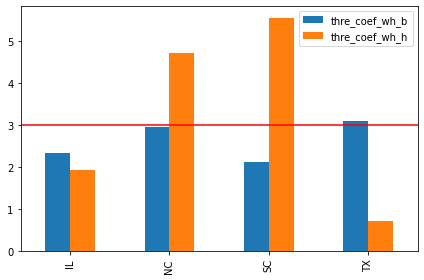

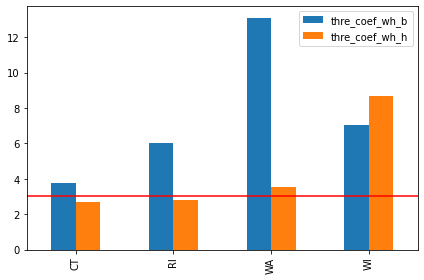

In [18]:
diverse_state.plot.bar()
plt.axhline(y=3,c='red')
plt.xticks(np.arange(4),diverse_state['state'])
plt.tight_layout()
plt.savefig('thre_diverse.png')
p_diverse_state.plot.bar()
plt.axhline(y=3,c='red')
plt.xticks(np.arange(4),p_diverse_state['state'])
plt.tight_layout()
plt.savefig('thre_poor_diverse.png')

### Discussion
### Observing the results, we could find that in four poor diverse states, the coefficients are all larger than 3, while only TX is larger than 3 in diverse state. This proves that in poor diverse state,  the population composition  is not commensurate with threshold, that is, the population ratio multiple is much greater than the threshold multiple, which proves that there exists bias in the police search behavior decision.